###### Inicialização

In [2]:
!pip install meteostat yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 16.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, date
from IPython.display import Markdown
from itertools import product

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots as tsa

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)

from meteostat import Point, Daily

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

import seaborn as sns
import plotly.graph_objects as go

In [4]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["figure.figsize"] = (22,6)

In [5]:
def resultado_adf(resultado, alpha = .05):
  adf, pvalue, usedlag, nobs, critical = resultado[0:5]
  
  display(Markdown('Statistics=%.3f, p-valor=%.8f' % (adf, pvalue)))
  # interpretando resultados
  if pvalue > alpha:
      display(Markdown("**A série não é estacionária (falhamos em rejeitar H0)**"))
  else:
      display(Markdown('**A série é estacionária (rejeitamos H0)**'))

Captura dos dados de temperatura

In [6]:
start = datetime(2018, 1, 1)
end = datetime(2022, 10, 31)

location = Point(-11.0056387, -37.2432436) #Aracaju

aracaju = Daily(location, start, end)
serie_aracaju = aracaju.fetch()

serie_aracaju.tavg.fillna(serie_aracaju.tavg.mean(),inplace=True)

# Análise de Séries temporais (Sessão 13)
---
Modelando Séries (parte 4)

## Modelos ARMA

Modelos ARMA são modelos que possuem uma estrutura de dependência tanto em relação às observações passadas $X_t, X_{t-1}, ...,$ assim como em relação às pertubações $ε_t, ε_{t-1}$, ... .

Então, esses modelos são um híbrido de modelos Autoregressivos AR(p) e modelos de Média Móvel MA(q):

\begin{align}
ARMA(p,q) = X_t= \color{blue}{α_1X_{t-1} + ... + α_pX_{t-p}} + ε_t + \color{green} {β_1ε_{t-1} + ... + β_qε_{t-q}}
\end{align}

com uma vantagem dupla:
1. Capacidade de simular uma quantidade muito maior de estruturas de dependência das séries temporais;
2. Frenquentemente, um ARMA(p,q) necessita uma quantidade menor de parâmetros que um AR(p) ou um MA(q) sozinhos.

Na prática, iremos considerar um processo ARMA $X_t$ (estacionário e média zero) deslocado em m, que é a média global da série temporal em análise:

\begin{align}
Y_t = m + X_t
\end{align}

#### Simulando um processo ARMA(1,1)

\begin{align}
x_t = 0.3x_{t-1} + 𝜀_t + 0.7 𝜀_{t-1}
\end{align}

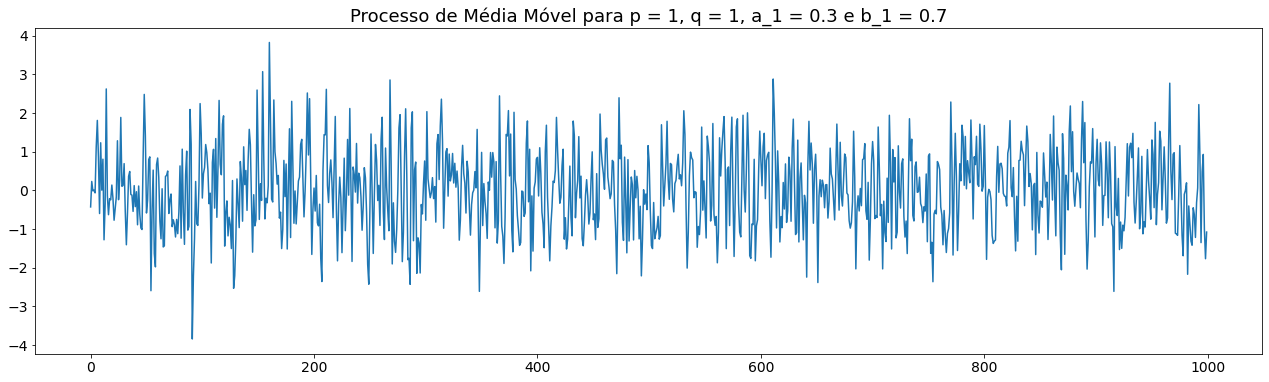

In [7]:
ar = np.array([1, .3])
ma = np.array([1, .7])

serie_arma11 = sm.tsa.ArmaProcess(ar, ma).generate_sample(nsample=1000)
serie_arma11 = pd.Series(serie_arma11)

_ = serie_arma11.plot(title = "Processo de Média Móvel para p = 1, q = 1, a_1 = 0.3 e b_1 = 0.7")

#### Simulando um processo ARMA(2,2)

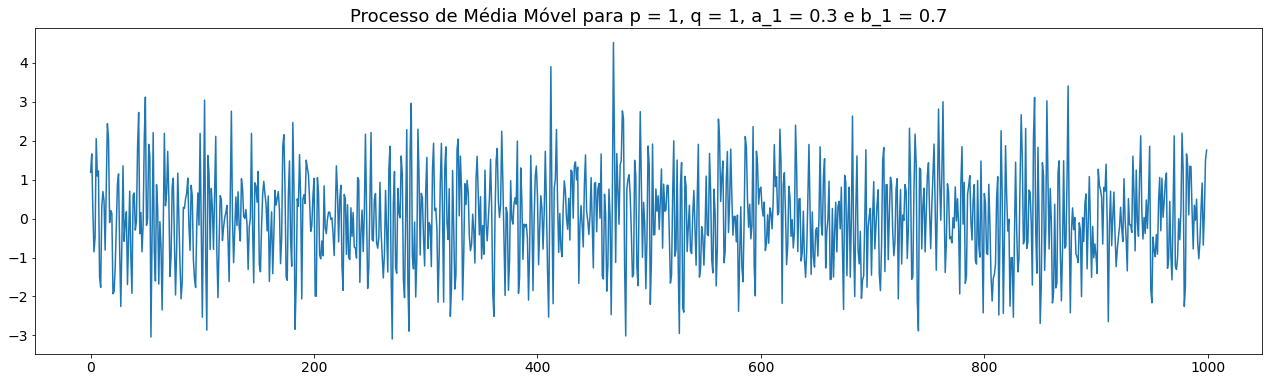

In [8]:
ar = np.array([1, .3, .5])
ma = np.array([1, .7, .2])

serie_arma22 = sm.tsa.ArmaProcess(ar, ma).generate_sample(nsample=1000)
serie_arma22 = pd.Series(serie_arma22)

_ = serie_arma22.plot(title = "Processo de Média Móvel para p = 1, q = 1, a_1 = 0.3 e b_1 = 0.7")

### Autocorrelação em Modelos ARMA

Em poucas palavras:
- Se o gráfico ACF diminuir gradualmente e o PACF cair instantaneamente, use o modelo Auto Regressivo.
- Se o gráfico ACF cair instantaneamente e o PACF diminuir gradualmente, use o modelo de média móvel.
- Se ACF e PACF diminuírem gradualmente, combine os modelos Auto Regressivo e Média Móvel (ARMA).
- Se ACF e PACF caírem instantaneamente (sem atrasos significativos), é provável que você não consiga modelar a série temporal.

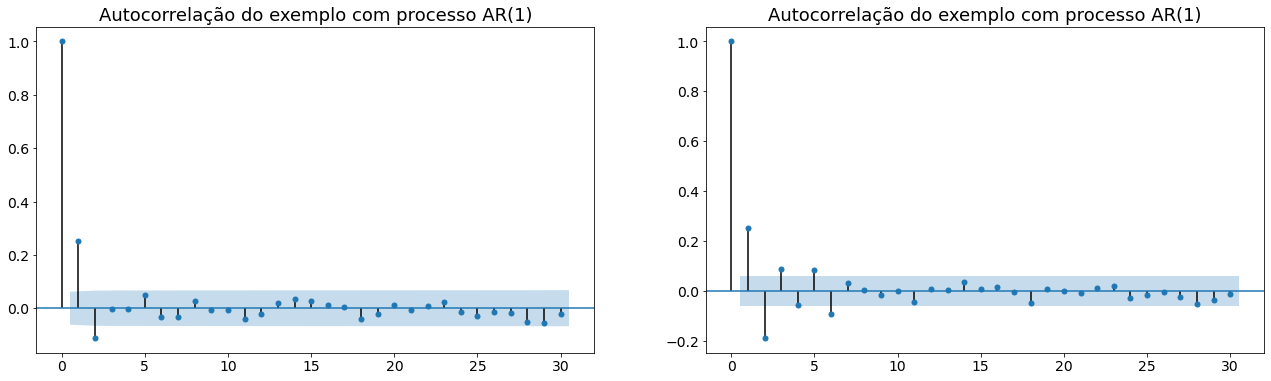

In [9]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(serie_arma11, ax = axs[0], title="Autocorrelação do exemplo com processo ARMA(1,1)")
_ = tsa.plot_pacf(serie_arma11, ax = axs[1], title="Autocorrelação do exemplo com processo ARMA(1,1)")

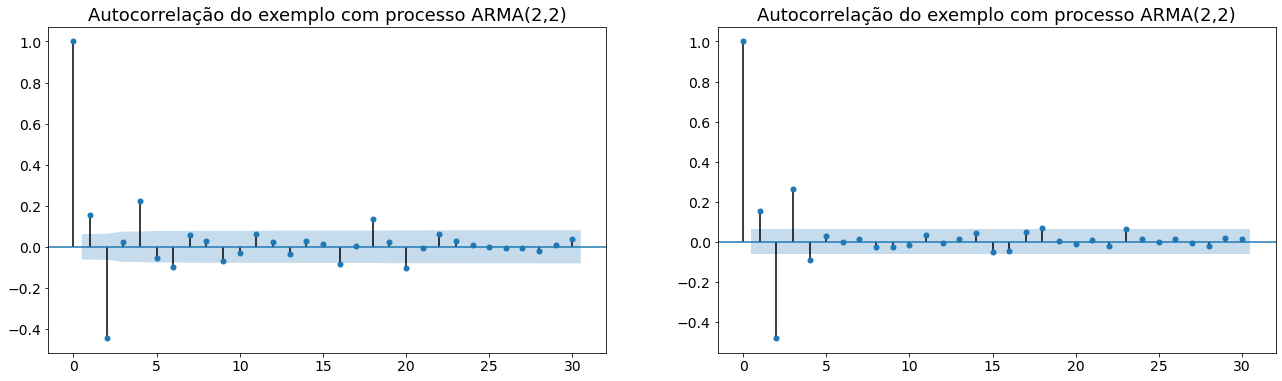

In [10]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(serie_arma22, ax = axs[0], title="Autocorrelação do exemplo com processo ARMA(2,2)")
_ = tsa.plot_pacf(serie_arma22, ax = axs[1], title="Autocorrelação do exemplo com processo ARMA(2,2)")


  Modelo | FAC | FACP
  -------|-----|----------
  AR(p)  | infinito / dec. exp. | corte em p
  MA(p)  | corte em q          | infinito / dec. exp.
  ARMA(p) | infinito / misto de dec. e corte | infinito / misto de dec. e corte



### Ajustamento

#### Ajustando o modelo ARMA(1,1)

In [11]:
modelo_arma11 = sm.tsa.arima.ARIMA(serie_arma11, order=(1,0,1)).fit()

In [12]:
print(modelo_arma11.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1409.528
Date:                Tue, 14 Feb 2023   AIC                           2827.056
Time:                        01:51:30   BIC                           2846.687
Sample:                             0   HQIC                          2834.517
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0192      0.039      0.489      0.625      -0.058       0.096
ar.L1         -0.3521      0.071     -4.949      0.000      -0.492      -0.213
ma.L1          0.6900      0.053     12.920      0.0

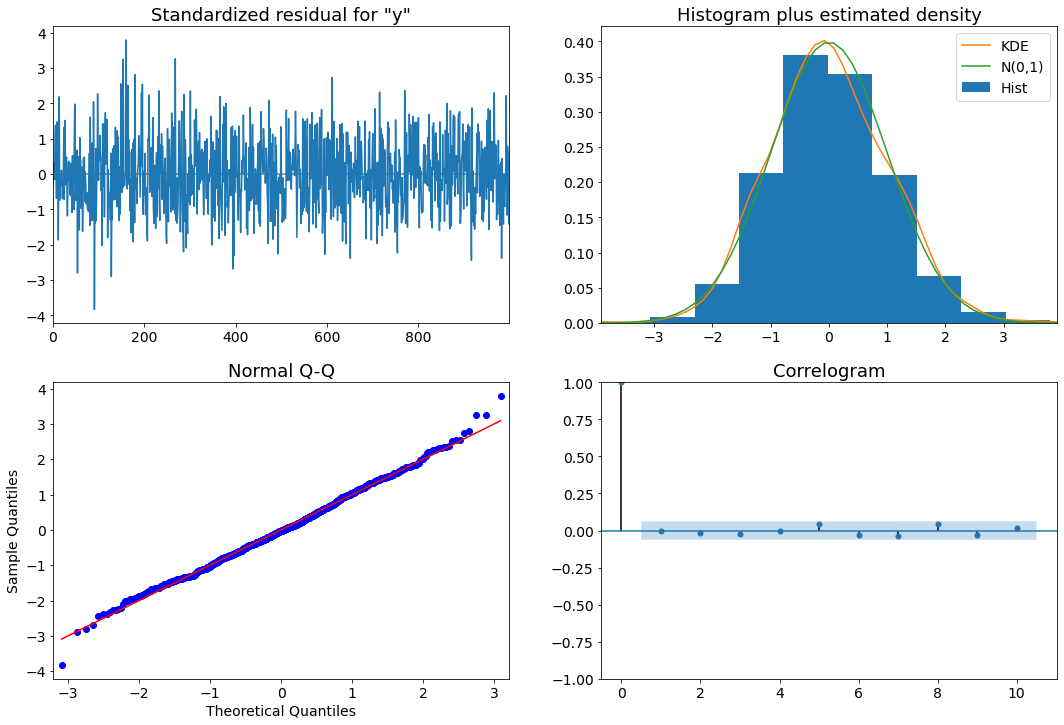

In [13]:
modelo_arma11.plot_diagnostics(figsize=(18,12));

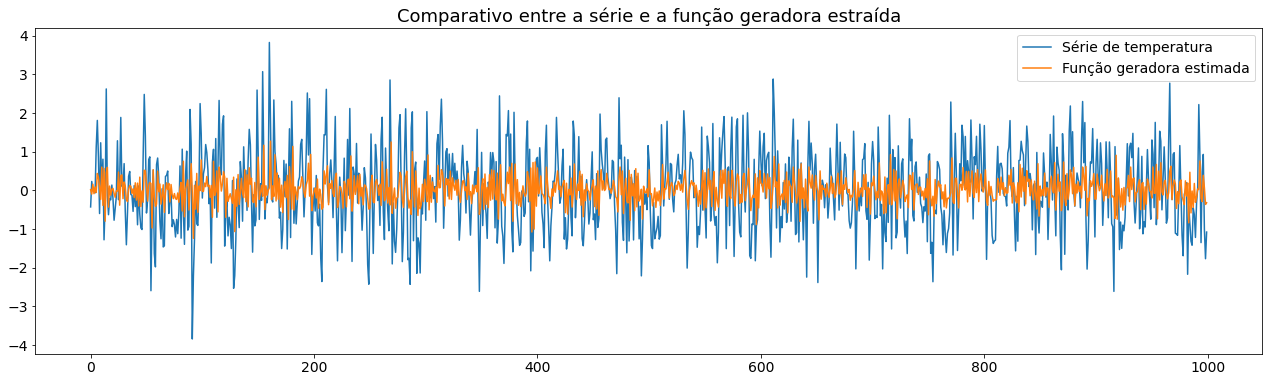

In [14]:
ax = serie_arma11.plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_arma11.fittedvalues.plot(ax = ax, label="Função geradora estimada", legend= True)

#### Austando o modelo ARMA(2,2)

In [15]:
modelo_arma22 = sm.tsa.arima.ARIMA(serie_arma22, order=(2,0,2)).fit()

In [16]:
print(modelo_arma22.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1416.177
Date:                Tue, 14 Feb 2023   AIC                           2844.353
Time:                        01:52:53   BIC                           2873.800
Sample:                             0   HQIC                          2855.545
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.032      0.132      0.895      -0.058       0.066
ar.L1         -0.2061      0.071     -2.914      0.004      -0.345      -0.068
ar.L2         -0.4956      0.046    -10.854      0.0

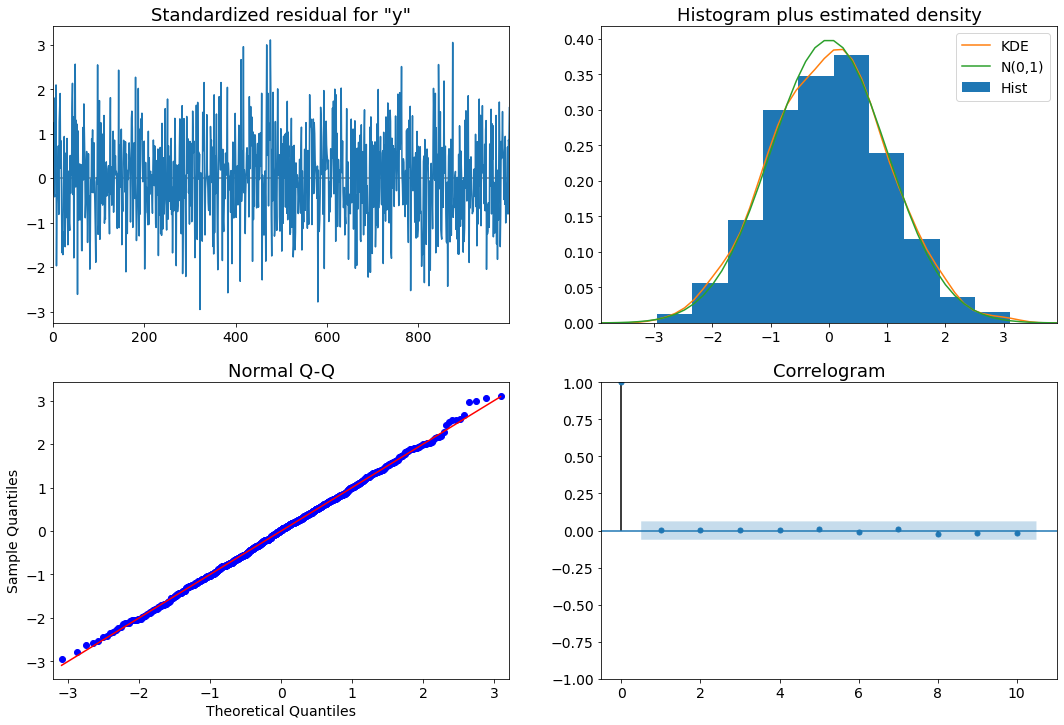

In [17]:
modelo_arma22.plot_diagnostics(figsize=(18,12));

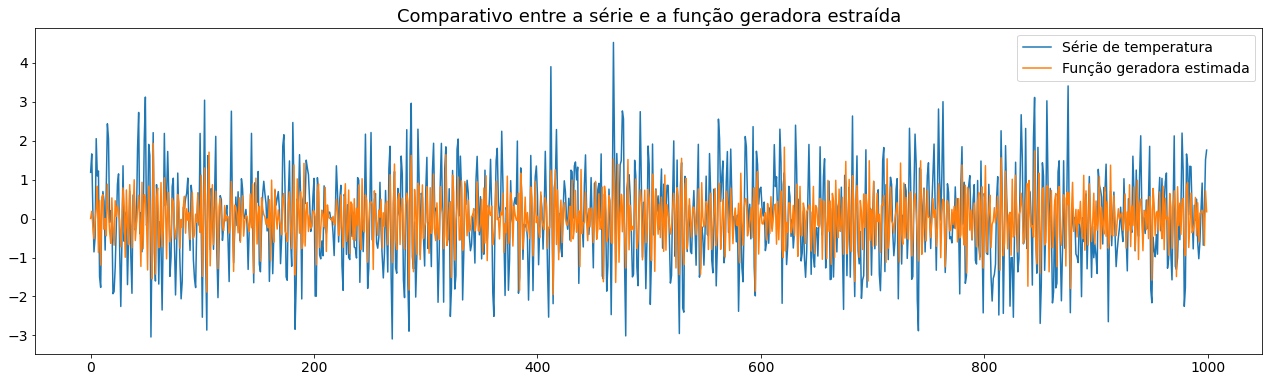

In [18]:
ax = serie_arma22.plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_arma22.fittedvalues.plot(ax = ax, label="Função geradora estimada", legend= True)

### Aplicando

In [19]:
y_aracaju_dif = ( serie_aracaju.tavg - serie_aracaju.tavg.mean() ).dropna().diff()[1:]

In [20]:
resultado_adf(sm.tsa.adfuller(y_aracaju_dif))

Statistics=-14.581, p-valor=0.00000000

**A série é estacionária (rejeitamos H0)**

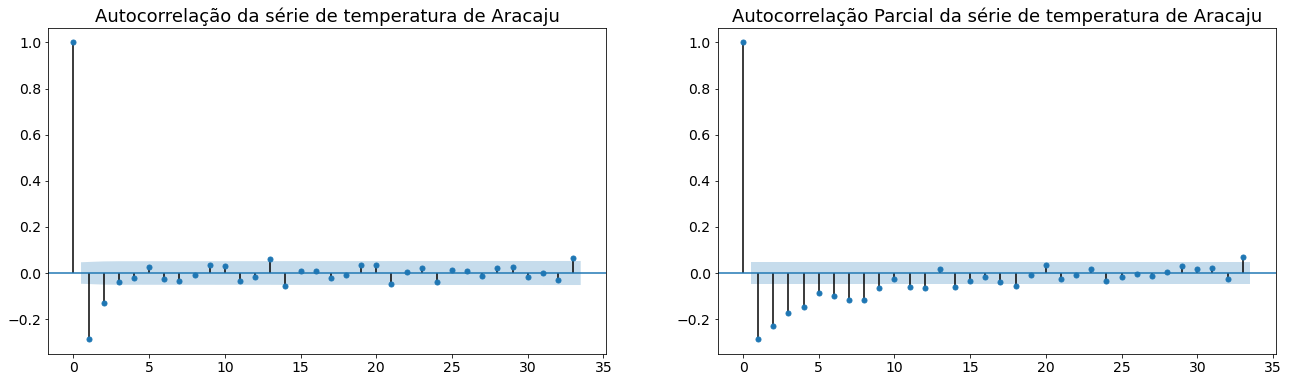

In [21]:
fig, axs = plt.subplots(1,2)
tsa.plot_acf(y_aracaju_dif, ax = axs[0], title="Autocorrelação da série de temperatura de Aracaju")
_ = tsa.plot_pacf(y_aracaju_dif, ax = axs[1], title="Autocorrelação Parcial da série de temperatura de Aracaju")

In [25]:
modelo_temperatura_arma = sm.tsa.arima.ARIMA(y_aracaju_dif, order=(2,0,1)).fit()

In [26]:
print(modelo_temperatura_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                   tavg   No. Observations:                 1764
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1740.912
Date:                Tue, 14 Feb 2023   AIC                           3491.823
Time:                        01:56:45   BIC                           3519.200
Sample:                    01-02-2018   HQIC                          3501.939
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.004     -0.112      0.911      -0.008       0.007
ar.L1          0.3917      0.028     14.207      0.000       0.338       0.446
ar.L2         -0.0159      0.025     -0.647      0.5

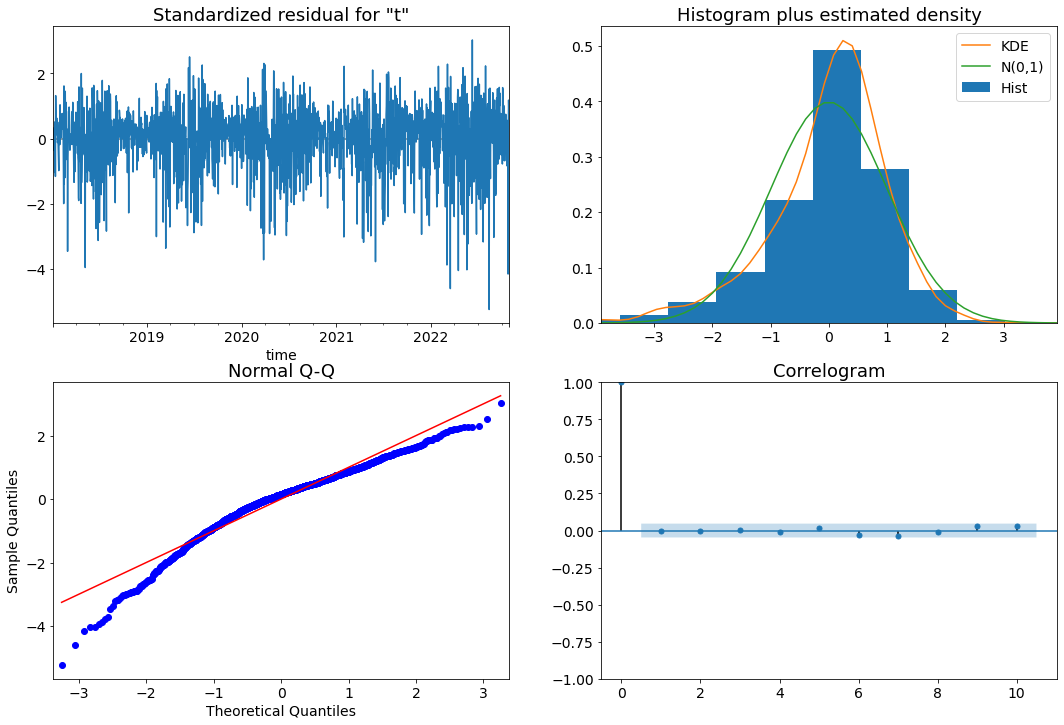

In [27]:
_ = modelo_temperatura_arma.plot_diagnostics(figsize=(18,12))

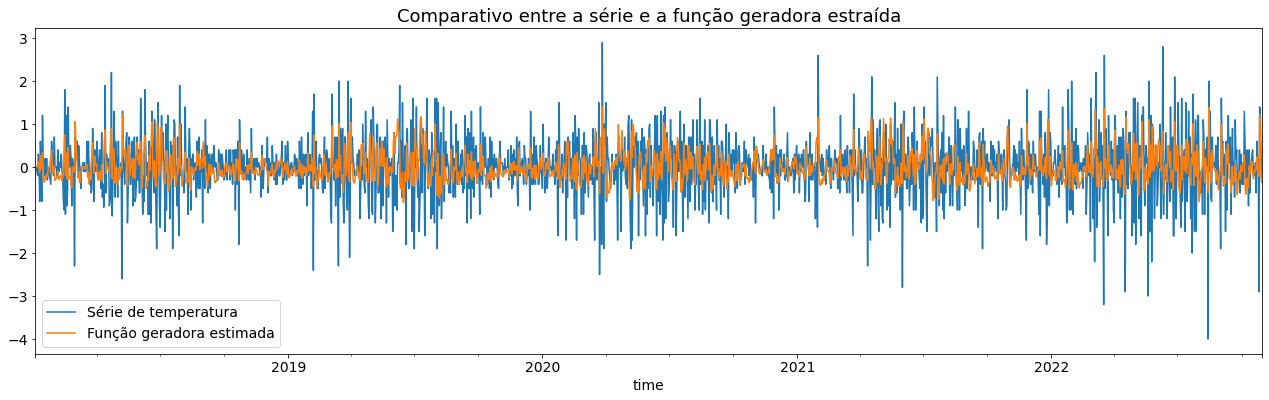

In [28]:
ax = y_aracaju_dif.plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_temperatura_arma.fittedvalues.plot(ax = ax, label="Função geradora estimada", legend= True)

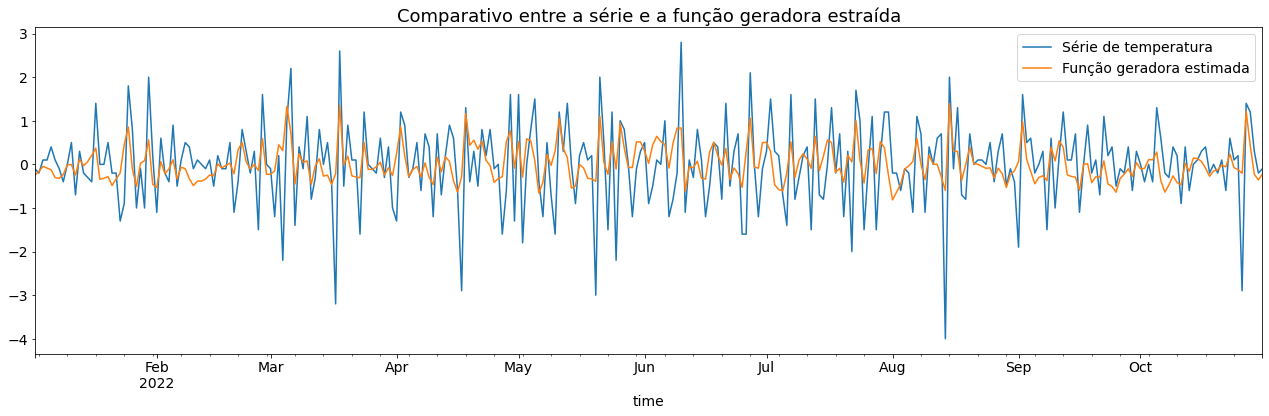

In [29]:
ax = y_aracaju_dif[y_aracaju_dif.index > "2022-01-01"].plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_temperatura_arma.fittedvalues[modelo_temperatura_arma.fittedvalues.index > "2022-01-01"].plot(ax = ax, label="Função geradora estimada", legend= True)

## Modelos AR**I**MA

Entretanto, há modelos que incorparam diretamente a tendência e/ou os efeitos sazonais, por exemplo:

O modelo ARIMA incorpora a tendência determinística da série temporal:
- A série $X_t$ segue um modelo ARIMA(p, d, q), se a diferença d de $X_t$ seguir um processo ARMA(p, q).
O modelo SARIMA incorpora a tendência dterminística e os efeitos sazonais da série temporal.

Vantagem: conferem rapidez e conviniência na previsão de séries temporais!

In [49]:
y_aracaju = ( serie_aracaju.tavg - serie_aracaju.tavg.mean() ).dropna()

In [31]:
modelo_temperatura_arima = sm.tsa.arima.ARIMA(y_aracaju, order=(2,1,1)).fit()

In [32]:
print(modelo_temperatura_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                   tavg   No. Observations:                 1765
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1740.921
Date:                Tue, 14 Feb 2023   AIC                           3489.842
Time:                        02:01:45   BIC                           3511.743
Sample:                    01-01-2018   HQIC                          3497.934
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3917      0.028     14.205      0.000       0.338       0.446
ar.L2         -0.0159      0.025     -0.648      0.517      -0.064       0.032
ma.L1         -0.8736      0.017    -51.563      0.0

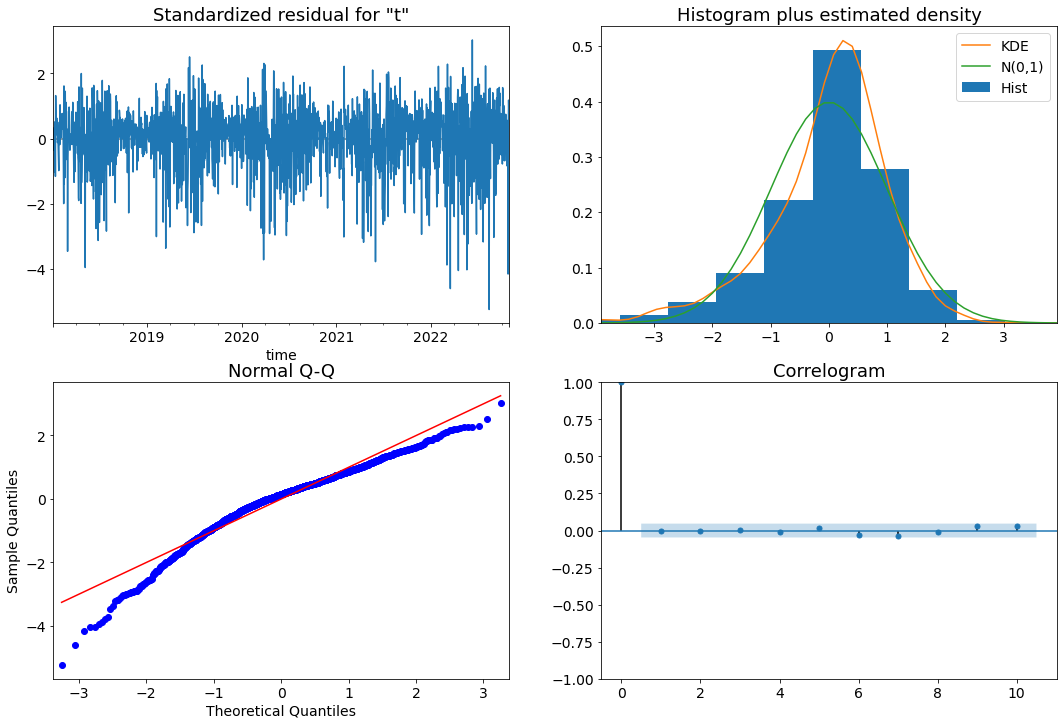

In [33]:
_ = modelo_temperatura_arima.plot_diagnostics(figsize=(18,12))

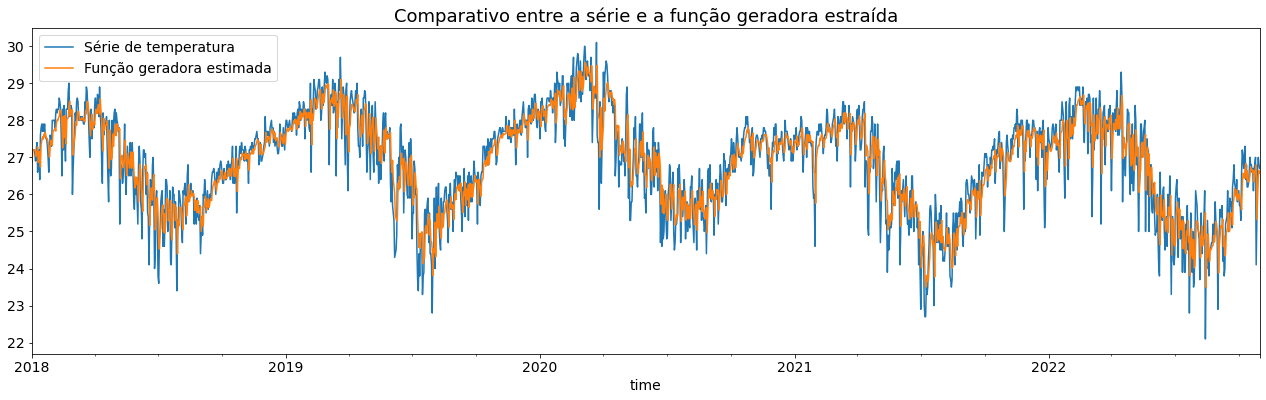

In [35]:
m = serie_aracaju.tavg.mean()
ax = (y_aracaju + m).plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = (modelo_temperatura_arima.fittedvalues + m).plot(ax = ax, label="Função geradora estimada", legend= True)

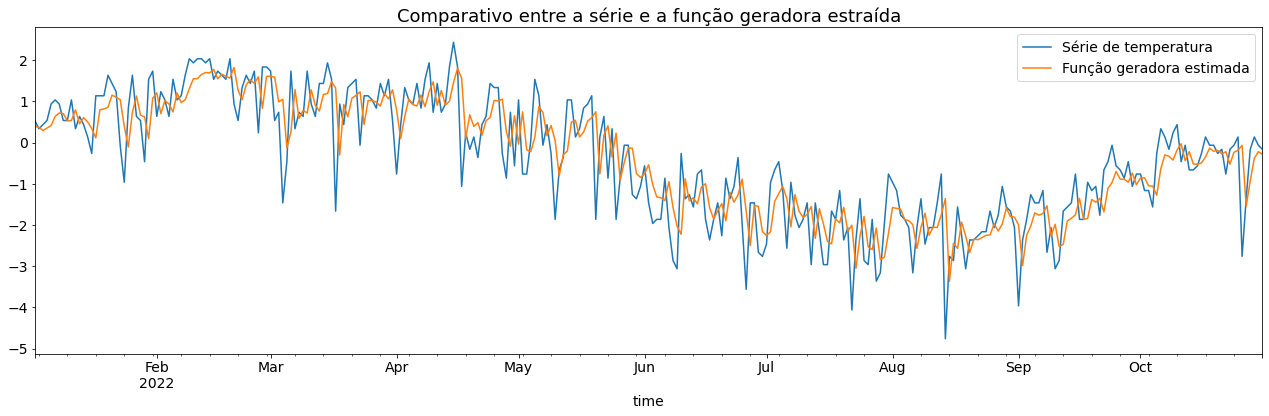

In [36]:
ax = y_aracaju[y_aracaju.index > "2022-01-01"].plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_temperatura_arima.fittedvalues[modelo_temperatura_arima.fittedvalues.index > "2022-01-01"].plot(ax = ax, label="Função geradora estimada", legend= True)

## Auto ARIMA

In [37]:
def auto_ARIMA(experimentos, dados):
  resultados = []
  
  for experimento in tqdm(experimentos):
    try: 
      modelo = sm.tsa.arima.ARIMA(dados, order=experimento).fit()
    except:
      continue
          
    resultados.append([experimento, modelo.aic, modelo])

  resultados_df = pd.DataFrame(resultados)
  resultados_df.columns = ['(p, d, q)', 'AIC', 'modelo']
  
  resultados = resultados_df.sort_values(by='AIC', ascending=True).reset_index(drop=True) #ordena pelo AIC
  
  return resultados

In [38]:
ps = range(1, 8, 1)
d = 1
qs = range(0, 3, 1)

parameters = product(ps, qs) # cria uma combinação de todos os parâmetros
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

In [40]:
result_df = auto_ARIMA(order_list, y_aracaju)
result_df

  0%|          | 0/21 [00:00<?, ?it/s]

,"(p, d, q)",AIC,modelo
0,"(1, 1, 1)",3488.206772,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,"(1, 1, 2)",3489.839176,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,"(2, 1, 1)",3489.841561,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,"(2, 1, 2)",3490.661702,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,"(3, 1, 1)",3491.839476,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,"(3, 1, 2)",3492.600745,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,"(7, 1, 1)",3493.259348,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,"(6, 1, 1)",3493.399982,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,"(4, 1, 1)",3493.716749,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,"(6, 1, 2)",3494.120212,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [50]:
modelo_temperatura_autoarima = result_df.modelo.iloc[0]

In [42]:
print(modelo_temperatura_autoarima.summary())

                               SARIMAX Results                                
Dep. Variable:                   tavg   No. Observations:                 1765
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1741.103
Date:                Tue, 14 Feb 2023   AIC                           3488.207
Time:                        02:08:13   BIC                           3504.633
Sample:                    01-01-2018   HQIC                          3494.276
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3906      0.028     14.153      0.000       0.337       0.445
ma.L1         -0.8776      0.015    -59.453      0.000      -0.907      -0.849
sigma2         0.4213      0.010     41.116      0.0

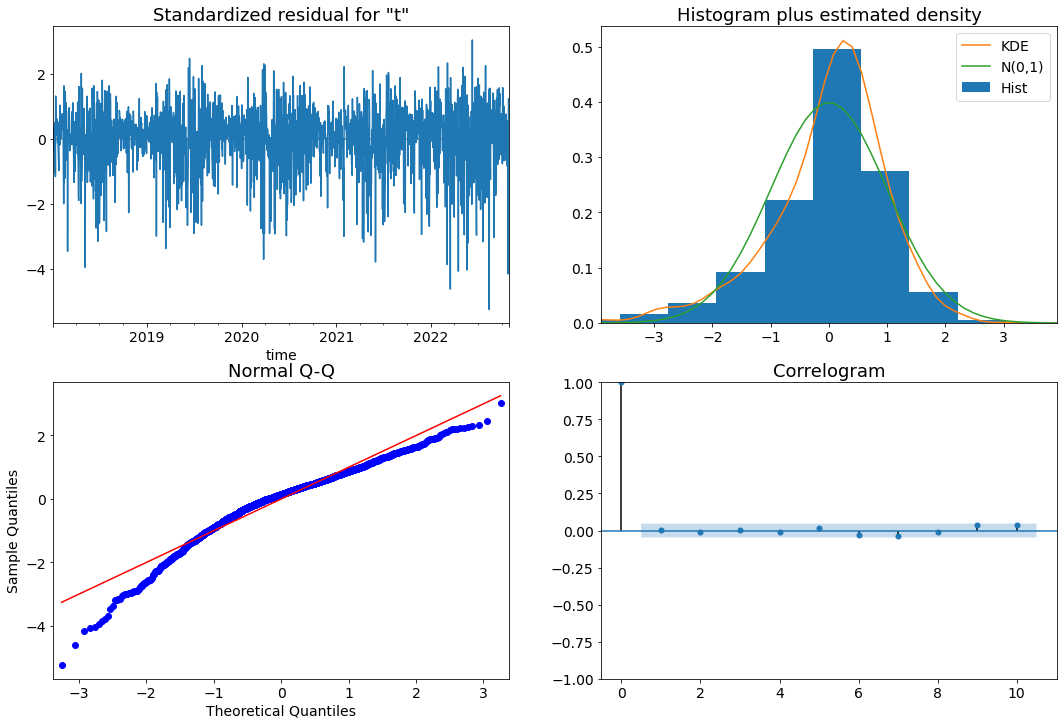

In [43]:
_ = modelo_temperatura_autoarima.plot_diagnostics(figsize=(18,12))

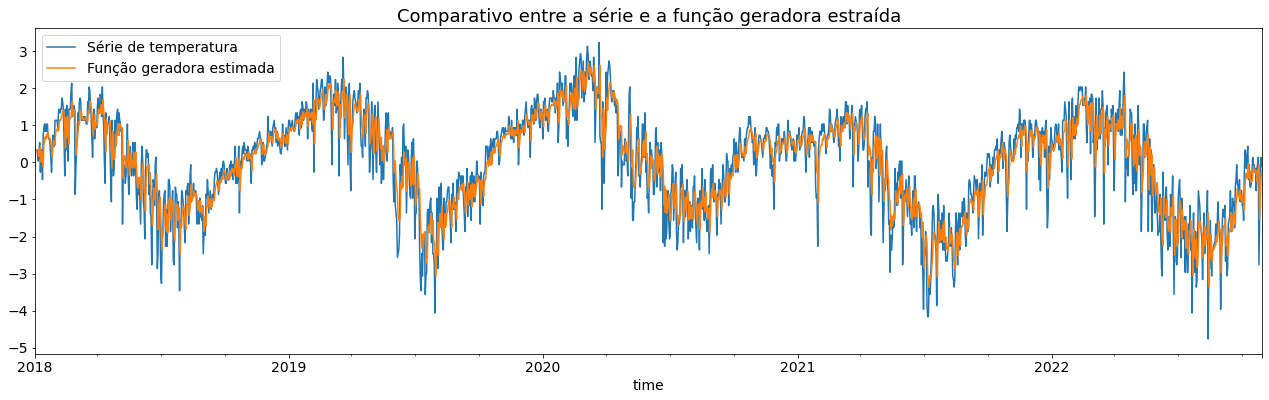

In [44]:
ax = y_aracaju.plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_temperatura_autoarima.fittedvalues.plot(ax = ax, label="Função geradora estimada", legend= True)

In [51]:
y_aracaju = y_aracaju + serie_aracaju.tavg.mean()
y_aracaju = y_aracaju[y_aracaju.index > "2022-01-01"]
modelo_arima = modelo_temperatura_autoarima.fittedvalues + serie_aracaju.tavg.mean()
modelo_arima = modelo_arima[modelo_arima.index > "2022-01-01"]

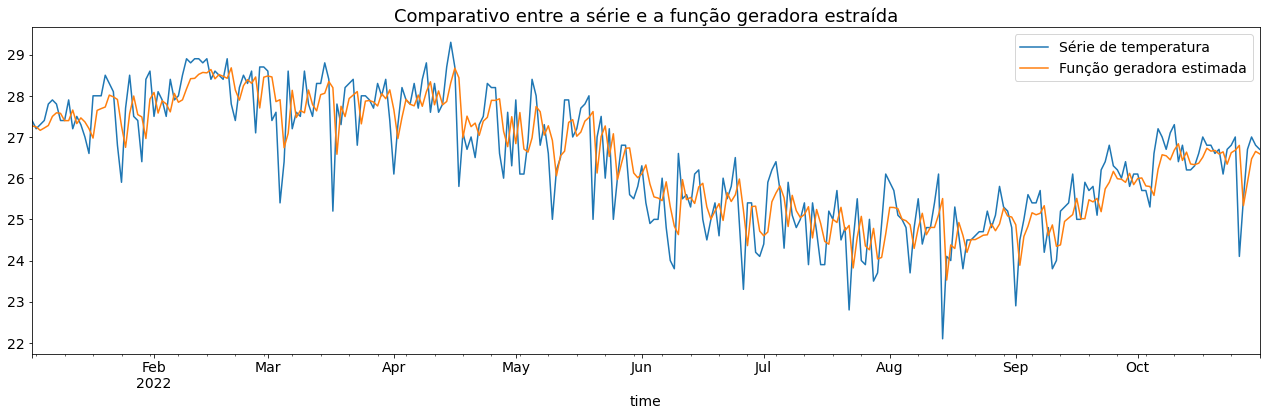

In [52]:
ax = y_aracaju.dropna().plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = modelo_arima.dropna().plot(ax = ax, label="Função geradora estimada", legend= True)

## Exercício

1. Ajuste um modelo ARMA para a série de temperatura de sua cidade, realize a análise de resíduos e compare a série com o modelo. Não esquecer de:
  - Ajustar a média para 0
  - Tornar a série estacionária
  - Valida se a série é estacionária utilizando o teste de estacionariedade.
2. Ajuste um modelo ARIMA para a série de temperatura de sua cidade, realize a análise de resíduos e compare a série com o modelo. Não esquecer de:
  - Ajustar a média para 0
  - A diferenciação já é algo que faz parte do modelo 
3. Utilize o Auto ARIMA para buscar o modelo que mais se ajusta à série de temperatura de sua cidade.